<a href="https://colab.research.google.com/github/Akif4362/mri_reconstruction/blob/main/mri_reconstruction_unet_T2_rep1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [47]:
import zipfile

zip_file = "/content/drive/MyDrive/T2_First.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/m4raw_data')
print("Unzipping complete!")

Unzipping complete!


In [48]:
zip_file = "/content/drive/MyDrive/T2_First_Test.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/m4raw_data')
print("Unzipping complete!")

Unzipping complete!


In [49]:
# Example: Load one .h5 file
h5_path = '/content/m4raw_data/T2_First/2022061001_T201.h5'  # Replace with an actual file name from your unzipped folder
with h5py.File(h5_path, 'r') as f:
    # Inspect the keys in the file
    print("Keys in .h5 file:", list(f.keys()))

    # Load k-space data (assuming 'kspace' is the key, adjust based on actual structure)
    kspace = np.array(f['kspace'])  # Shape: [repetitions, coils, height, width] or similar

    # Load reference image if available (optional, for supervised training)
    if 'reconstruction' in f:
        reference = np.array(f['reconstruction'])

# Check the shape of the k-space data
print("K-space shape:", kspace.shape)

Keys in .h5 file: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
K-space shape: (18, 4, 256, 256)


In [50]:
def create_undersampling_mask(shape, acceleration=4):
    height, width = shape[-2], shape[-1]
    mask = np.zeros((height, width), dtype=np.float32)
    num_lines = height // acceleration
    center = height // 2
    mask[center - num_lines//2:center + num_lines//2, :] = 1  # Keep central lines
    return mask

# Apply mask to k-space (example for one repetition, one coil)
kspace_undersampled = kspace[0, 0] * create_undersampling_mask(kspace.shape)

In [51]:
def kspace_to_image(kspace, apply_rss=True):
    # kspace shape: [coils, height, width] or [height, width] if single coil
    kspace_shifted = np.fft.ifftshift(kspace, axes=(-2, -1))
    img = np.fft.ifft2(kspace_shifted)
    img_shifted = np.fft.fftshift(img)

    if apply_rss and len(kspace.shape) == 3:  # Multi-coil case
      return np.sqrt(np.sum(np.abs(img_shifted) ** 2, axis=0))  # RSS across coils
    return np.abs(img_shifted)  # Magnitude for single coil

In [52]:
class M4RawDataset(Dataset):
    def __init__(self, h5_dir, acceleration=4):
        import os
        self.h5_files = [os.path.join(h5_dir, f) for f in os.listdir(h5_dir) if f.endswith('.h5')]
        self.acceleration = acceleration

    def __len__(self):
        return len(self.h5_files)

    def __getitem__(self, idx):
        file_path = self.h5_files[idx]
        with h5py.File(file_path, 'r') as f:
            kspace = np.array(f['kspace'])[0]  # Shape: [coils, height, width] (first repetition)
            mask = create_undersampling_mask(kspace.shape[1:], self.acceleration)
            kspace_undersampled = kspace * mask[np.newaxis, :, :]  # Broadcast mask
            zero_filled = kspace_to_image(kspace_undersampled, apply_rss=True)
            target = kspace_to_image(kspace, apply_rss=True)
            # Return file name with data
            return zero_filled, target, os.path.basename(file_path)  # Use basename to get just the file name



In [53]:
train_dataset = M4RawDataset('/content/m4raw_data/T2_First')
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = M4RawDataset('/content/m4raw_data/T2_First_Test')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [54]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

In [55]:
model = UNet().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for zero_filled, target, filenames in train_dataloader:
        zero_filled, target = zero_filled.float().cuda(), target.float().cuda()
        zero_filled = zero_filled.unsqueeze(1)  # Add channel dimension
        target = target.unsqueeze(1)

        optimizer.zero_grad()
        output = model(zero_filled)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.00022991342120803893
Epoch 2, Loss: 0.00023268329096026719
Epoch 3, Loss: 0.0001753040123730898
Epoch 4, Loss: 0.0001850621192716062
Epoch 5, Loss: 0.00019350173533894122
Epoch 6, Loss: 0.00013903492072131485
Epoch 7, Loss: 0.00016681314446032047
Epoch 8, Loss: 0.00019400057499296963
Epoch 9, Loss: 0.00015913837705738842
Epoch 10, Loss: 0.00013904101797379553


Reconstructing file: 2022062706_T201.h5


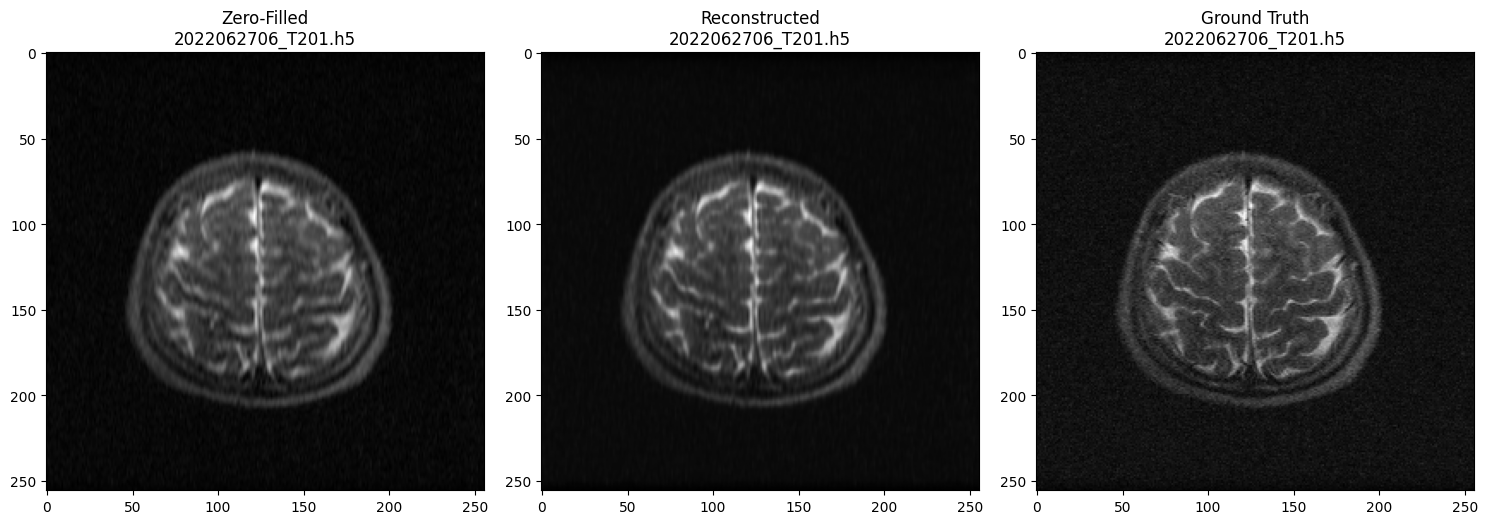

Reconstructing file: 2022111801_T201.h5


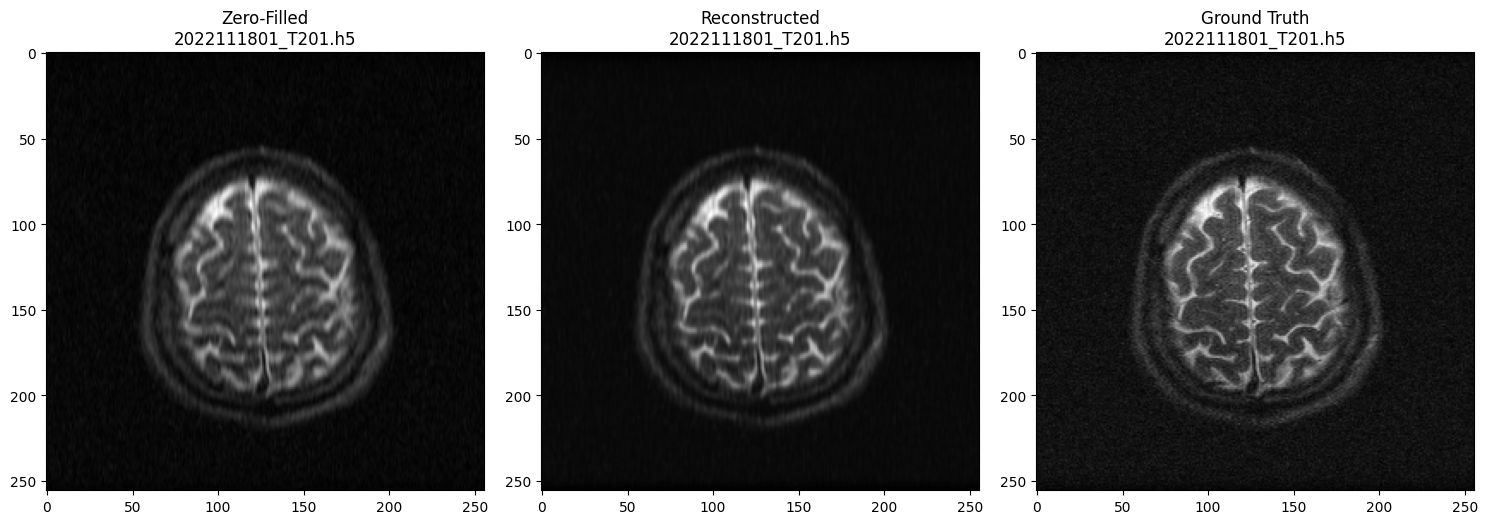

In [57]:
# evaluate on a single image from training dataset
model.eval()
with torch.no_grad():
    zero_filled, target, filenames = next(iter(train_dataloader))
    zero_filled = zero_filled.float().cuda().unsqueeze(1)
    target = target.float()
    reconstructed = model(zero_filled).cpu().squeeze(1).numpy()
    zero_filled = zero_filled.cpu().squeeze(1).numpy()

    for i in range(len(filenames)):
        print(f"Reconstructing file: {filenames[i]}")
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title(f"Zero-Filled\n{filenames[i]}")
        plt.imshow(zero_filled[i], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title(f"Reconstructed\n{filenames[i]}")
        plt.imshow(reconstructed[i], cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"Ground Truth\n{filenames[i]}")
        plt.imshow(target[i], cmap='gray')
        plt.tight_layout()
        plt.show()

Test file: 2022101101_T201.h5


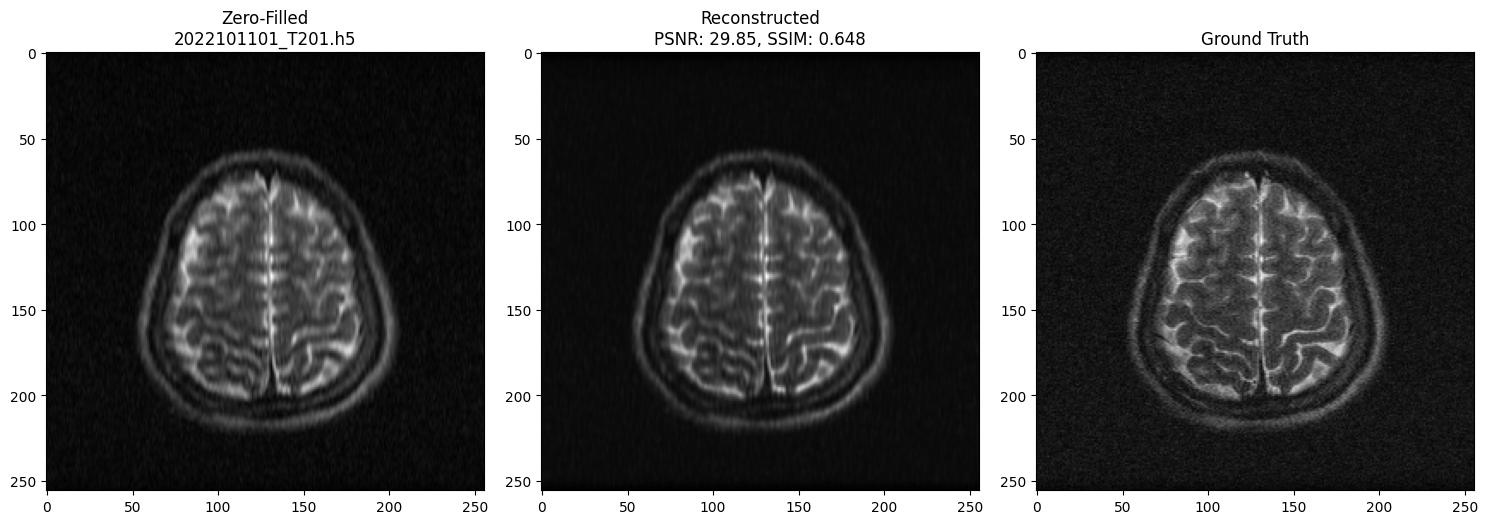

Test file: 2022120406_T201.h5


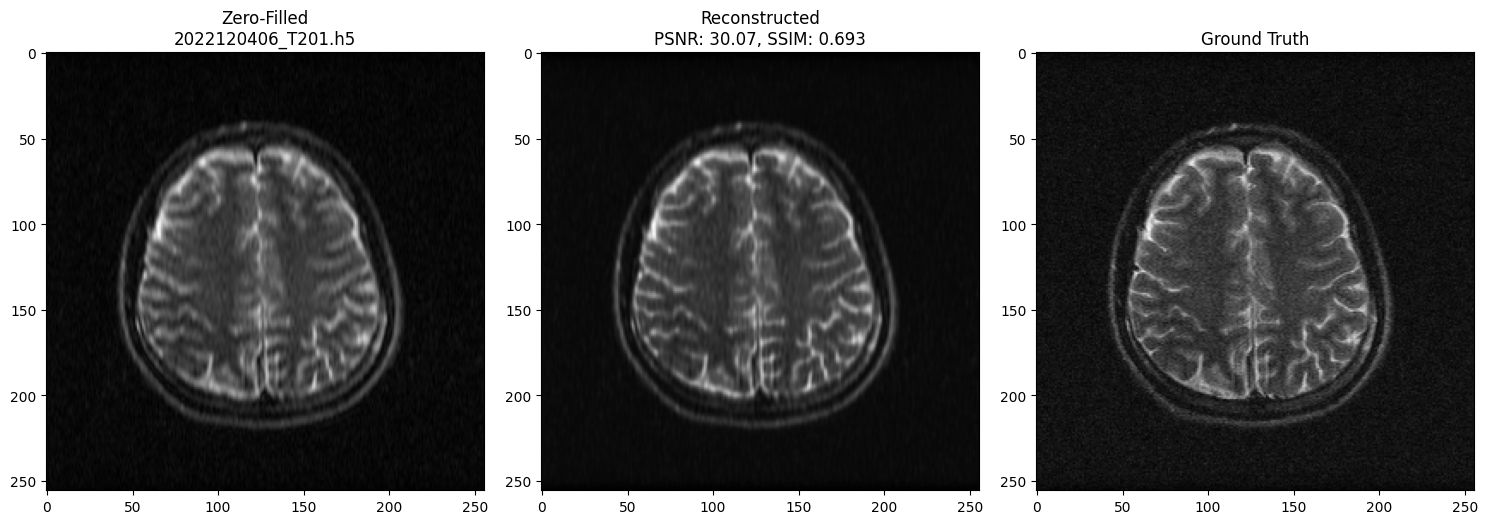

Test file: 2022121702_T201.h5


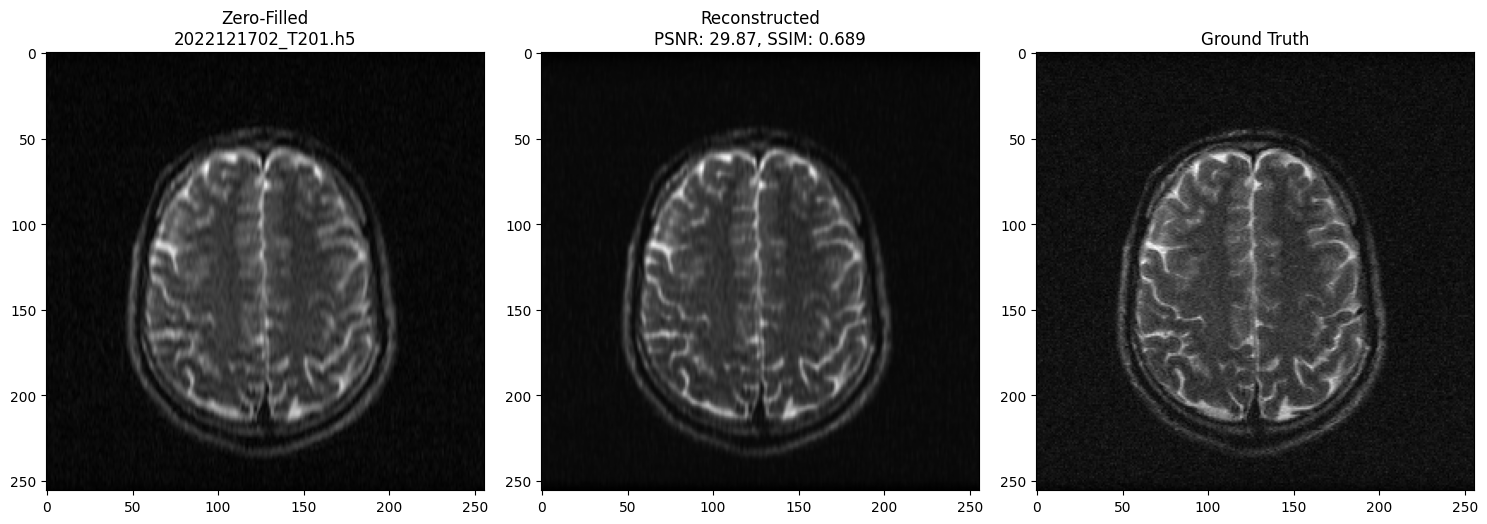

Test file: 2022101302_T201.h5


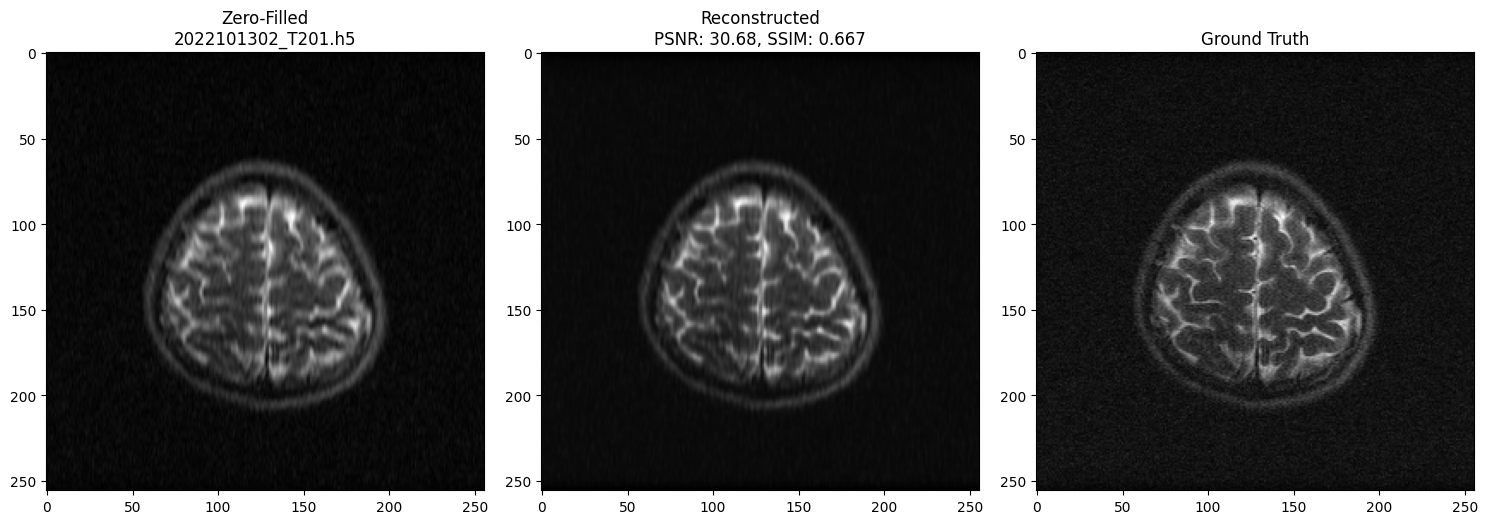

Test file: 2022121701_T201.h5


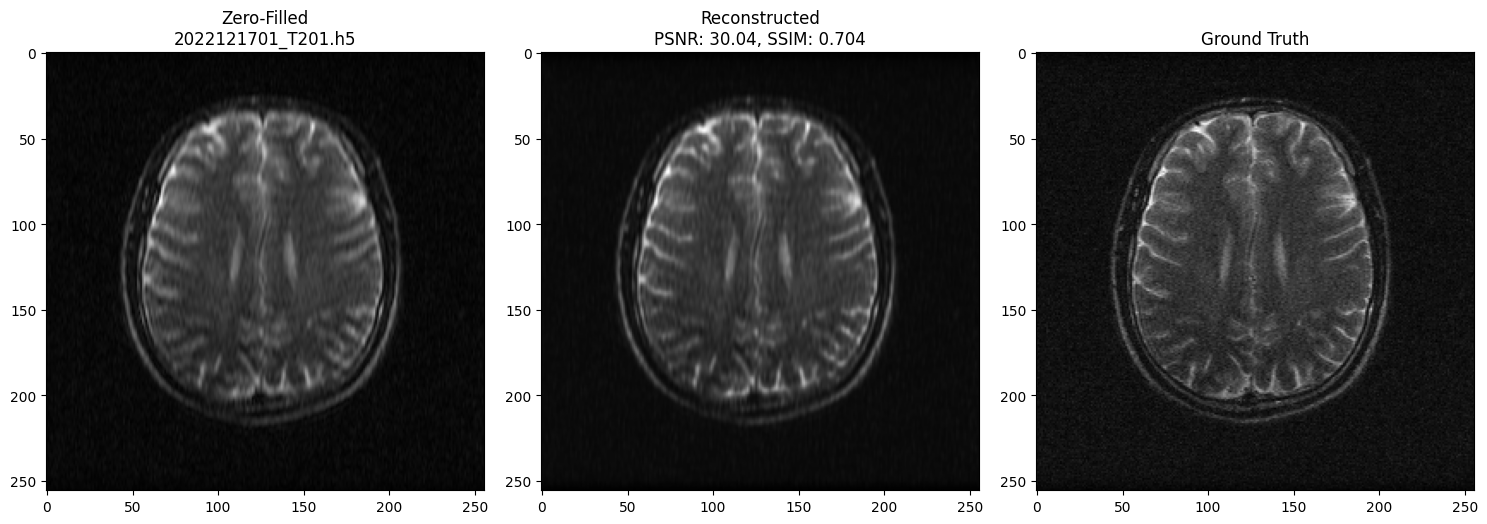


Test Set Evaluation Metrics:
Average PSNR: 30.18 dB
Average SSIM: 0.678
Average MSE: 0.000168
Average NMSE: 0.026083


In [58]:
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


def evaluate_model(model, test_loader):
    model.eval()
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    nmse_scores = []
    all_results = []

    with torch.no_grad():
        for zero_filled, target, filenames in test_loader:
            zero_filled = zero_filled.float().cuda().unsqueeze(1)
            target = target.float().numpy()
            reconstructed = model(zero_filled).cpu().squeeze(1).numpy()
            zero_filled_np = zero_filled.cpu().squeeze(1).numpy()

            for i in range(len(filenames)):
                recon_img = reconstructed[i]
                gt_img = target[i]
                zero_img = zero_filled_np[i]

                recon_img_norm = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min() + 1e-8)
                gt_img_norm = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min() + 1e-8)

                psnr_val = psnr(gt_img, recon_img, data_range=gt_img.max() - gt_img.min())
                ssim_val = ssim(gt_img_norm, recon_img_norm, data_range=1.0)
                mse_val = np.mean((gt_img - recon_img) ** 2)
                nmse_val = mse_val / np.mean(gt_img ** 2)

                psnr_scores.append(psnr_val)
                ssim_scores.append(ssim_val)
                mse_scores.append(mse_val)
                nmse_scores.append(nmse_val)

                all_results.append((zero_img, recon_img, gt_img, filenames[i], psnr_val, ssim_val))

    num_samples = min(5, len(all_results))
    random_samples = random.sample(all_results, num_samples)

    for zero_img, recon_img, gt_img, filename, psnr_val, ssim_val in random_samples:
        print(f"Test file: {filename}")
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title(f"Zero-Filled\n{filename}")
        plt.imshow(zero_img, cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title(f"Reconstructed\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.3f}")
        plt.imshow(recon_img, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"Ground Truth")
        plt.imshow(gt_img, cmap='gray')
        plt.tight_layout()
        plt.show()

    print("\nTest Set Evaluation Metrics:")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_scores):.3f}")
    print(f"Average MSE: {np.mean(mse_scores):.6f}")
    print(f"Average NMSE: {np.mean(nmse_scores):.6f}")

    return psnr_scores, ssim_scores, mse_scores, nmse_scores

# Run evaluation
psnr_scores, ssim_scores, mse_scores, nmse_scores = evaluate_model(model, test_dataloader)